# Deliverable 2

#### Relevant information on delivery 2

- Deliverable 2 will be a NER.


- The Final dataset will be given to you this week. You will have a train a validation and a test set.


- The validation set can only be used to choose your model. All your models have to be evaluated on the train and the validation set.


- The model with highest validation set must be then evaluated on the test set.


#### Evaluation 

- Model quality on validation and test (average F1 score)


- Testing different models is very important.


- Testing a model with different parameters is very important.


- Both things should be documented in tables and the table should come from a piece of code that should be referenced on the documentation provided


- I want you to test at least:
    - A structured perceptron model.
    - A neural net architecture.
    
    
- It would be nice to also test
    - A model applied with a slyding window at every position of the sequence (it won't get good results but it is a nice exercise) to see how much you improve using more sophisticated tools.
    
    
- Feature generation/preprocessing is rellevant and will be taken into account.





# We already saw an example of Recurrent neural networks for named entity recognition

## Overview of the data

url = https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus


Essential info about entities:

```
geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time indicator
art = Artifact
eve = Event
nat = Natural Phenomenon
```


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [2]:
!ls ../data/

books               kaggle_ner          people_wiki.csv.zip
conll               people_data.txt     spanish_line.txt


In [3]:
! head ../data/kaggle_ner/entity-annotated-corpus/ner_dataset.csv

In [4]:
data = pd.read_csv("../data/kaggle_ner/entity-annotated-corpus/ner_dataset.csv",
                   encoding="latin1")

In [5]:
data.head(26)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


 Fill with "Sentence: k" for each k

In [6]:
sentences = list(set(data["Sentence #"]))
sentences[0] = "nan"
sentences.sort()
len(sentences)

47960

In [7]:
sentences[0:3]

['Sentence: 1', 'Sentence: 10', 'Sentence: 100']

In [8]:
set(data["Tag"])

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

In [9]:
for tag in set(data["Tag"]):
    print("\nTAG:",tag)
    print(data[data["Tag"] == tag]["Word"][0:10])


TAG: B-tim
167    Wednesday
211    Wednesday
274      Tuesday
341    Wednesday
493    Wednesday
654       Sunday
679     Saturday
684       Friday
740     Saturday
848     Thursday
Name: Word, dtype: object

TAG: I-eve
4854      Summer
4855    Olympics
5036     Olympic
5171      Medusa
5764         War
6730        Open
6756     Classic
6834        Open
9990         War
9991          II
Name: Word, dtype: object

TAG: I-tim
1479       8
1993       1
4137       2
4148       3
4979      of
4980    2005
7896      25
7897       ,
7898    1995
8254       7
Name: Word, dtype: object

TAG: I-per
271         Mahmoud
272     Ahmadinejad
332         Horbach
444       Abdullahi
445           Yusuf
446           Ahmad
966        Muhammad
974          Khayam
1106     Faridullah
1107           Khan
Name: Word, dtype: object

TAG: B-geo
6        London
12         Iraq
65         Hyde
94      Britain
106    Brighton
118        Iraq
133      London
146        Rome
148       Paris
151      Madrid
Name: 

How many sentences do we have?

In [10]:
"Sentence: 47959" in sentences, "Sentence: 47960" in sentences

(True, False)

## Indexing Sentences

In [11]:
sentence_formatter = "Sentence: {}"
sentence_formatter.format(0) in sentences

False

In [12]:
sentence_formatter = "Sentence: {}"
sentence_formatter.format(1) in sentences

True

In [13]:
i = 1
sentence_id      = sentence_formatter.format(i)
sentence_id_next = sentence_formatter.format(i+1)
sentence_id, sentence_id_next

('Sentence: 1', 'Sentence: 2')

In [14]:
print(data.index[data["Sentence #"] == sentence_id])
print(data.index[data["Sentence #"] == sentence_id_next])

Int64Index([0], dtype='int64')
Int64Index([24], dtype='int64')


In [15]:
start = data.index[data["Sentence #"] == sentence_id][0]
end   =  data.index[data["Sentence #"] == sentence_id_next][0]
start, end

(0, 24)

In [16]:
data["Sentence #"][start:end] = sentence_id

In [17]:
data["Sentence #"][start:end]

0     Sentence: 1
1     Sentence: 1
2     Sentence: 1
3     Sentence: 1
4     Sentence: 1
5     Sentence: 1
6     Sentence: 1
7     Sentence: 1
8     Sentence: 1
9     Sentence: 1
10    Sentence: 1
11    Sentence: 1
12    Sentence: 1
13    Sentence: 1
14    Sentence: 1
15    Sentence: 1
16    Sentence: 1
17    Sentence: 1
18    Sentence: 1
19    Sentence: 1
20    Sentence: 1
21    Sentence: 1
22    Sentence: 1
23    Sentence: 1
Name: Sentence #, dtype: object

## Selecting a subset and writting an identifier

In [18]:
data = pd.read_csv("../data/kaggle_ner/entity-annotated-corpus/ner_dataset.csv",
                   encoding="latin1")

last_n = 2000
end   = data.index[data["Sentence #"] == sentence_formatter.format(last_n)][0]

In [19]:
data = data[0:end]

In [20]:
n_sentences = len(list(set(data["Sentence #"])))
first_n = 1
last_n = last_n -1
print(n_sentences)

2000


In [21]:
%%time 
sentence_formatter = "Sentence: {}"

for s_id in  range(first_n, last_n):
    print("current {}/{}".format(s_id,last_n), end="\r")
    sentence_id = sentence_formatter.format(s_id)
    sentence_id_next = sentence_formatter.format(s_id + 1)
    start = data.index[data["Sentence #"] == sentence_id][0]
    end   = data.index[data["Sentence #"] == sentence_id_next][0]
    data["Sentence #"][start:end] = sentence_id
    
sentence_id = sentence_formatter.format(last_n)
start = data.index[data["Sentence #"] == sentence_id][0]
end   = data.shape[0]
data["Sentence #"][start:end] = sentence_id


CPU times: user 8.07 s, sys: 288 ms, total: 8.36 s
Wall time: 8.26 s


## Building X and Y

In [22]:
n_sentences

2000

In [ ]:
X = []
Y = []

sentence_formatter = "Sentence: {}"

for i in range(1,n_sentences):
    s = sentence_formatter.format(i)
    X.append(list(data[data["Sentence #"]==s]["Word"].values))
    Y.append(list(data[data["Sentence #"]==s]["Tag"].values))

In [ ]:
i = 0
xy = ["{}/{}".format(x,y) for x,y in zip(X[i],Y[i])]
" ".join(xy)

In [ ]:
def build_word_to_pos(X):

    word_to_pos = {}
    i = 0
    for s in X:
        for w in s:
            if w not in word_to_pos:
                word_to_pos[w] = i
                i +=1
                
    pos_to_word = {v: k for k, v in word_to_pos.items()}
    return word_to_pos, pos_to_word
            
def build_tag_to_pos(Y):
    tag_to_pos = {}
    i = 0
    for s in Y:
        for t in s:
            if t not in tag_to_pos:
                tag_to_pos[t] = i
                i +=1
    pos_to_tag = {v: k for k, v in tag_to_pos.items()}

    return tag_to_pos, pos_to_tag

In [ ]:
word_to_pos, pos_to_word = build_word_to_pos(X)
tag_to_pos, pos_to_tag  = build_tag_to_pos(Y)

len(word_to_pos), len(tag_to_pos)

In [ ]:
tag_to_pos

In [ ]:
X = [[word_to_pos[w] for w in s] for s in X]
Y = [[tag_to_pos[t] for t in s] for s in Y]

In [ ]:
X[0]

# Keras GRU NER 

You can install it with
```
conda install -c conda-forge tensorflow 
pip install keras
```


In [ ]:
import tensorflow
import keras

In [ ]:
from keras.preprocessing.sequence import pad_sequences
max_len = max([len(x) for x in X])
n_words = len(word_to_pos)
n_tags  = len(tag_to_pos)

In [ ]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
Y = pad_sequences(maxlen=max_len, sequences=Y, padding="post", value=tag_to_pos["O"])

In [ ]:
X[0]

In [ ]:
from keras.utils import to_categorical

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, GRU
from keras.layers import Embedding, Dense, TimeDistributed, Dropout, Bidirectional

Notice that Keras wants classes to be enconded in a one hot encoding fashion

In [ ]:
Y = [to_categorical(i, num_classes=n_tags) for i in Y]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.1)

## Define the model 


In [177]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
#model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = Bidirectional(GRU(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out   = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

In [178]:
model = Model(input, out)

In [179]:
model.compile(optimizer="rmsprop", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [220]:
model

In [213]:
model.get_layer(index=0).get_config()

{'batch_input_shape': (None, 62),
 'dtype': 'float32',
 'sparse': False,
 'name': 'input_7'}

In [214]:
model.get_layer(index=1).get_config()

{'name': 'embedding_7',
 'trainable': True,
 'batch_input_shape': (None, 62),
 'dtype': 'float32',
 'input_dim': 7047,
 'output_dim': 50,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'activity_regularizer': None,
 'embeddings_constraint': None,
 'mask_zero': False,
 'input_length': 62}

In [215]:
model.get_layer(index=2).get_config()

{'name': 'dropout_7',
 'trainable': True,
 'rate': 0.1,
 'noise_shape': None,
 'seed': None}

In [216]:
model.get_layer(index=3).get_config()

{'name': 'bidirectional_7',
 'trainable': True,
 'layer': {'class_name': 'GRU',
  'config': {'name': 'gru_6',
   'trainable': True,
   'return_sequences': True,
   'return_state': False,
   'go_backwards': False,
   'stateful': False,
   'unroll': False,
   'units': 100,
   'activation': 'tanh',
   'recurrent_activation': 'hard_sigmoid',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'uniform',
     'seed': None}},
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'kernel_regularizer': None,
   'recurrent_regularizer': None,
   'bias_regularizer': None,
   'activity_regularizer': None,
   'kernel_constraint': None,
   'recurrent_constraint': None,
   'bias_constraint': None,
   'dropout': 0.0,
   'recurrent_dropout': 0.1,
   'implementation': 1,
   'reset_after': Fal

In [217]:
model.get_layer(index=4).get_config()

{'name': 'time_distributed_7',
 'trainable': True,
 'layer': {'class_name': 'Dense',
  'config': {'name': 'dense_7',
   'trainable': True,
   'units': 17,
   'activation': 'softmax',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'uniform',
     'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'kernel_regularizer': None,
   'bias_regularizer': None,
   'activity_regularizer': None,
   'kernel_constraint': None,
   'bias_constraint': None}}}

In [162]:
history = model.fit(X_tr, 
                    np.array(y_tr), 
                    batch_size=32, 
                    epochs=5, 
                    validation_split=0.1,
                    verbose=1)

Train on 1619 samples, validate on 180 samples
Epoch 1/5
1619/1619 [==============================] - 4s 2ms/step - loss: 0.5981 - acc: 0.9288 - val_loss: 0.2715 - val_acc: 0.9445
Epoch 2/5
1619/1619 [==============================] - 2s 1ms/step - loss: 0.2565 - acc: 0.9471 - val_loss: 0.2390 - val_acc: 0.9445
Epoch 3/5
1619/1619 [==============================] - 2s 1ms/step - loss: 0.2056 - acc: 0.9481 - val_loss: 0.1785 - val_acc: 0.9488
Epoch 4/5
1619/1619 [==============================] - 2s 1ms/step - loss: 0.1552 - acc: 0.9550 - val_loss: 0.1418 - val_acc: 0.9568
Epoch 5/5
1619/1619 [==============================] - 2s 1ms/step - loss: 0.1266 - acc: 0.9606 - val_loss: 0.1271 - val_acc: 0.9628


## Inspect results

In [125]:
hist = pd.DataFrame(history.history)

In [126]:
hist

,val_loss,val_acc,loss,acc
0,0.266290,0.944534,0.572358,0.928191
1,0.214716,0.945789,0.240753,0.947180
2,0.153689,0.955735,0.176131,0.951334
3,0.130416,0.961111,0.134375,0.959643
4,0.115133,0.967115,0.111574,0.965839


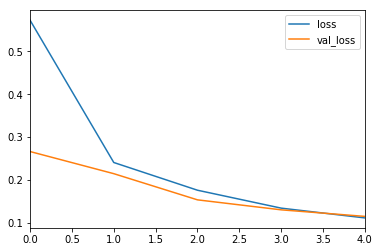

In [127]:
hist[["loss","val_loss"]].plot()

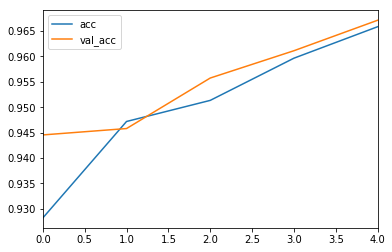

In [163]:
hist[["acc","val_acc"]].plot()

In [129]:
X_te[0]

array([1817,  151,  968,    9,  340,   51,    1, 1790, 1053, 1054, 1081,
       1490,    1,  666,   21, 7046, 7046, 7046, 7046, 7046, 7046, 7046,
       7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046,
       7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046,
       7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046, 7046,
       7046, 7046, 7046, 7046, 7046, 7046, 7046], dtype=int32)

### Making predictions

The function `model.predict` allow us to make predictions

In [143]:
y_hat = model.predict(np.array([X_te[i]]))


Those numbers are the probabilities for each class



In [144]:
y_hat.shape

(1, 62, 17)

In [145]:
len(tag_to_pos)

17

In [147]:
y_hat.shape

(1, 62, 17)

In [154]:
y_hat_batch = model.predict(X_te[0:4])

In [156]:
y_hat_batch.shape

(4, 62, 17)

## Inspecting mistakes

In [157]:
i = 0
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    #print(w)
    print("{:15}: {}".format(pos_to_word[w], pos_to_tag[pred]))

Word            (True ): Pred
Egypt          : I-per
has            : O
had            : O
the            : O
largest        : O
number         : O
of             : O
human          : O
bird           : O
flu            : O
cases          : O
outside        : O
of             : O
Asia           : B-tim
.              : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca         : O
Oaxaca      

# Use Structured perceptron with the provided dada

Add new features to the structured perceptron to deal with particular classes found in your data


The class ExtendedFeatures can be expanded.

For example you can add inside the method add_emission_features the following:



```
        if word.istitle():
            # Generate feature name.
            feat_name = "uppercased::%s" % y_name
            # Get feature ID from name.
            feat_id = self.add_feature(feat_name)
            # Append feature.
            if feat_id != -1:
                features.append(feat_id)
```